# Convolutional Neural Networks with PyTorch and FashionMNIST

In this notebook, we'll explore Convolutional Neural Networks (CNNs) using PyTorch and the FashionMNIST dataset. We'll cover both theoretical concepts and practical implementation, building a TinyVGG model from scratch.


In [1]:
# Import necessary libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## Introduction to Convolutional Neural Networks

Convolutional Neural Networks (CNNs) are a specialized type of neural network designed specifically for processing structured grid data like images. Unlike traditional neural networks, CNNs are built with layers specifically designed to detect spatial hierarchies and patterns in data.

### Key Components of CNNs:

1. **Convolutional Layers:** These layers apply filters (kernels) to input data to extract features. Each filter slides across the input, performing element-wise multiplications and summing to produce a feature map.

   ![Convolution Operation](https://miro.medium.com/v2/resize:fit:1400/1*Fw-ehcNBR9byHtho-Rxbtw.gif)

2. **Pooling Layers:** These reduce the spatial dimensions of the data, decreasing computational load while retaining important information.

   ![Pooling Operation](https://miro.medium.com/v2/resize:fit:700/1*uoWYsCV5vBU8SHFPAPao-w.gif)

3. **Fully Connected Layers:** Typically placed at the end of the network to perform classification based on the features extracted by earlier layers.

   ![CNN Architecture](https://miro.medium.com/v2/resize:fit:1400/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

### Advantages of CNNs for Image Processing:

- **Parameter Sharing:** Each filter is applied across the entire image, reducing the number of parameters compared to fully connected networks.
- **Translation Invariance:** The ability to detect features regardless of their position in the image.
- **Hierarchical Feature Learning:** Early layers detect simple features (like edges), while deeper layers combine these to recognize complex patterns.

### The FashionMNIST Dataset:

FashionMNIST consists of 60,000 training images and 10,000 testing images of fashion items across 10 categories. Each image is a 28×28 grayscale image. It serves as a more challenging alternative to the traditional MNIST dataset.

The 10 classes in FashionMNIST are:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

![FashionMNIST Examples](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

Let's load the dataset and visualize some examples:


In [2]:
# Define the transform to normalize the data
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert images to PyTorch tensors
    ]
)

# Download and load the training and test datasets
train_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=transform
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transform
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define class names for FashionMNIST
class_names = train_data.classes

# Display dataset information
print(f"Training dataset size: {len(train_data)}")
print(f"Test dataset size: {len(test_data)}")
print(f"Number of classes: {len(class_names)}")
print(f"Image shape: {train_data[0][0].shape}")

Training dataset size: 60000
Test dataset size: 10000
Number of classes: 10
Image shape: torch.Size([1, 28, 28])


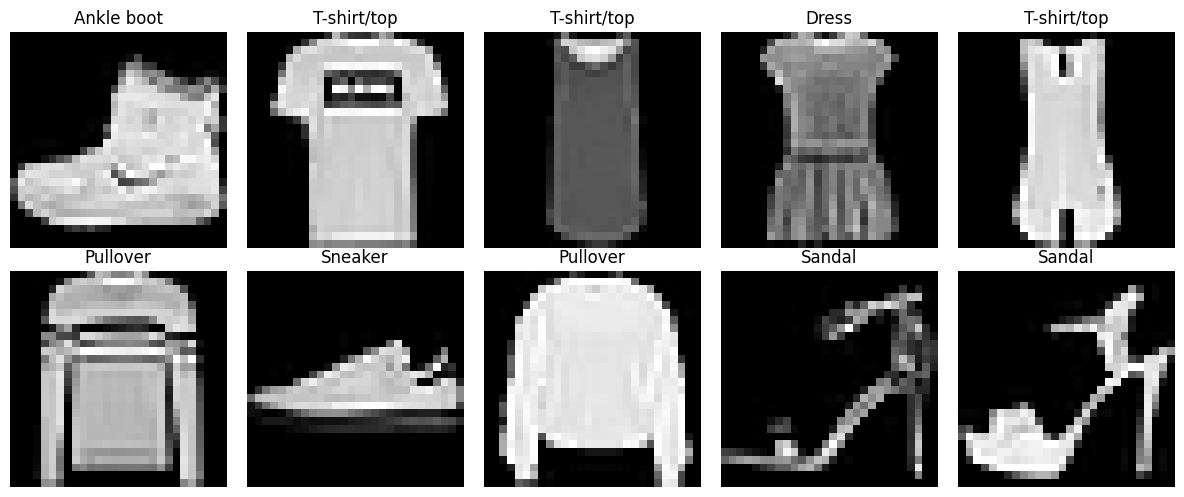

Batch shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


In [3]:
# Function to show an image
def show_image(img, label=None):
    plt.imshow(
        img.squeeze(), cmap="gray"
    )  # Remove color channel dimension and set colormap to gray
    plt.axis("off")
    if label is not None:
        plt.title(class_names[label])


# Visualize multiple images from the training set
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img, label = train_data[i]
    show_image(img, label)
plt.tight_layout()
plt.show()

# Get a sample batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

## Understanding Conv2d Layer

The `nn.Conv2d` is the cornerstone of CNNs in PyTorch. It applies a 2D convolution over an input signal composed of several input planes.

### Key Parameters:

- **in_channels**: Number of input channels (for grayscale images like FashionMNIST, this is 1)
- **out_channels**: Number of output channels (number of filters/kernels)
- **kernel_size**: Size of the convolving kernel (can be a single number or a tuple)
- **stride**: Stride of the convolution (default: 1)
- **padding**: Zero-padding added to both sides of the input (default: 0)

### How Convolution Works:

1. A filter (or kernel) slides over the input image
2. At each position, it performs an element-wise multiplication with the overlapping section of the image
3. The products are summed up to produce a single value in the output feature map
4. This process is repeated for each filter, creating multiple feature maps

![Convolution Details](https://miro.medium.com/v2/resize:fit:1400/1*1okwhewf5KCtIPaFib4XaA.gif)

Let's implement a single Conv2d layer and visualize its effect on a FashionMNIST image:


Image shape: torch.Size([1, 28, 28])
Label: Ankle boot


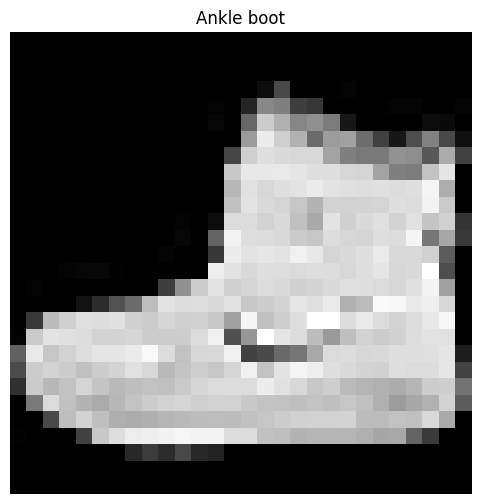

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 6, 28, 28])


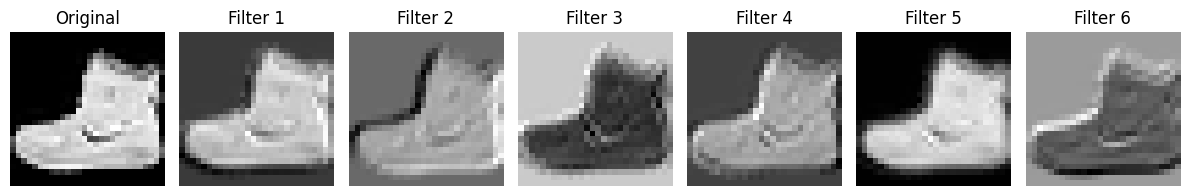


What happens in Conv2d:
1. The input image (28x28) is convolved with 6 different filters (3x3)
2. Each filter produces one feature map
3. With padding=1, the output size remains 28x28
4. The values in each feature map represent detected patterns


In [4]:
# Get a single image for demonstration
sample_img, sample_label = train_data[0]
print(f"Image shape: {sample_img.shape}")
print(f"Label: {class_names[sample_label]}")

# Display the original image
plt.figure(figsize=(6, 6))
show_image(sample_img, sample_label)
plt.show()

# Define a Conv2d layer
# Parameters: in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1
conv_layer = nn.Conv2d(
    in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1
)

# Apply the conv layer to our image
# Add batch dimension first
sample_img_batch = sample_img.unsqueeze(0)  # Shape: [1, 1, 28, 28]
output_features = conv_layer(sample_img_batch)

print(f"Input shape: {sample_img_batch.shape}")
print(f"Output shape: {output_features.shape}")

# Visualize the original and feature maps
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 7, 1)
show_image(sample_img)
plt.title("Original")

# Feature maps
for i in range(6):
    plt.subplot(1, 7, i + 2)
    plt.imshow(output_features[0, i].detach().numpy(), cmap="gray")
    plt.axis("off")
    plt.title(f"Filter {i+1}")

plt.tight_layout()
plt.show()

# Mathematical explanation of what happens in Conv2d
print("\nWhat happens in Conv2d:")
print("1. The input image (28x28) is convolved with 6 different filters (3x3)")
print("2. Each filter produces one feature map")
print("3. With padding=1, the output size remains 28x28")
print("4. The values in each feature map represent detected patterns")

## Understanding MaxPool2d Layer

The `nn.MaxPool2d` layer is used to reduce the spatial dimensions (width and height) of the input volume for the next convolutional layer. This serves two main purposes:

1. It reduces the computational load
2. It helps with feature extraction by providing a form of translation invariance

### Key Parameters:

- **kernel_size**: The size of the window to take the maximum over
- **stride**: The stride of the window (default: kernel_size)
- **padding**: Implicit zero padding to be added on both sides (default: 0)

### How MaxPooling Works:

1. A sliding window moves across the feature map
2. For each window position, it selects the maximum value
3. This maximum value becomes the value in the output feature map for that position
4. This effectively downsamples the feature map, reducing its dimensions

Let's implement a MaxPool2d layer and visualize its effect:


Before pooling: torch.Size([1, 6, 28, 28])
After pooling: torch.Size([1, 6, 14, 14])


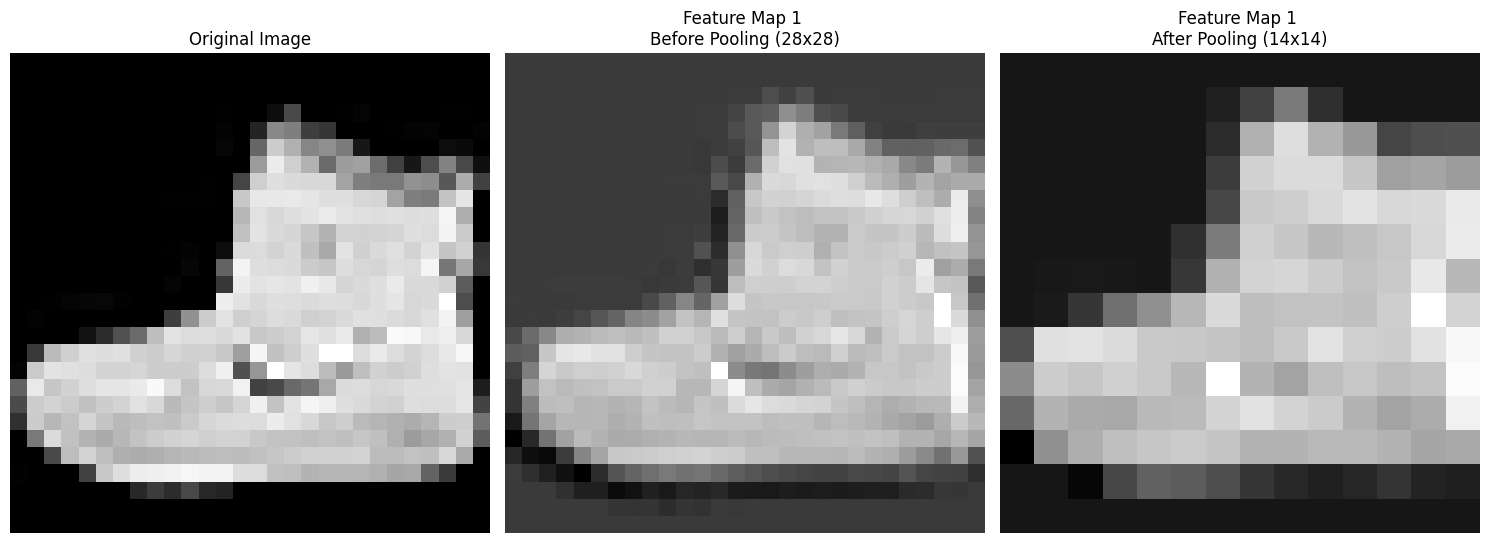

Small 4x4 section from feature map:
[[0.26 0.26 0.26 0.26]
 [0.26 0.26 0.26 0.26]
 [0.26 0.26 0.26 0.26]
 [0.26 0.26 0.26 0.26]]

After 2x2 max pooling:
[[0.26 0.26]
 [0.26 0.26]]


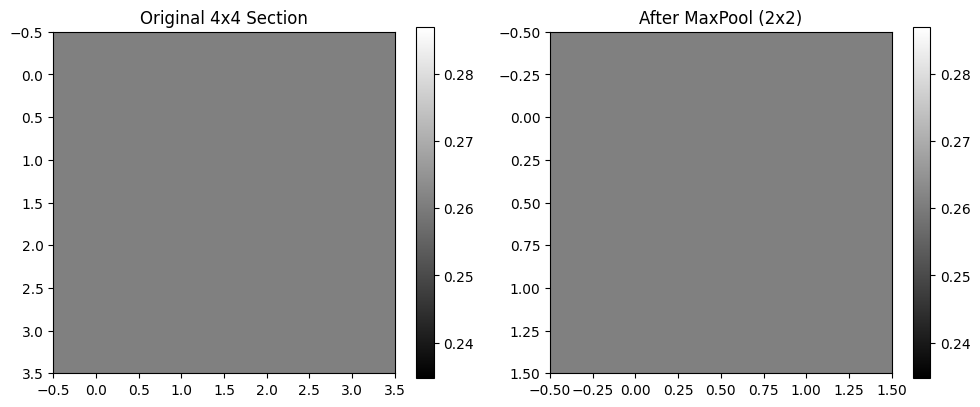

In [5]:
# Define a MaxPool2d layer
# kernel_size=2, stride=2 (default)
pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)

# Apply pooling to our feature maps
pooled_features = pool_layer(output_features)

print(f"Before pooling: {output_features.shape}")
print(f"After pooling: {pooled_features.shape}")

# Visualize the effect of pooling
plt.figure(figsize=(15, 6))

# Select one feature map to visualize (let's use the first one)
feature_map_idx = 0

# Original feature map
plt.subplot(1, 3, 1)
plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Feature map before pooling
plt.subplot(1, 3, 2)
plt.imshow(output_features[0, feature_map_idx].detach().numpy(), cmap="gray")
plt.title(f"Feature Map {feature_map_idx+1} \nBefore Pooling (28x28)")
plt.axis("off")

# Feature map after pooling
plt.subplot(1, 3, 3)
plt.imshow(pooled_features[0, feature_map_idx].detach().numpy(), cmap="gray")
plt.title(f"Feature Map {feature_map_idx+1} \nAfter Pooling (14x14)")
plt.axis("off")

plt.tight_layout()
plt.show()


# Demonstrate the max pooling operation manually for a small section
def demonstrate_max_pool(feature_map, pool_size=2):
    # Take a small section from the feature map
    small_section = feature_map[0, feature_map_idx, 0:4, 0:4].detach().numpy()

    print("Small 4x4 section from feature map:")
    print(np.round(small_section, 2))

    # Manually perform max pooling
    pooled = np.zeros((2, 2))

    pooled[0, 0] = np.max(small_section[0:2, 0:2])
    pooled[0, 1] = np.max(small_section[0:2, 2:4])
    pooled[1, 0] = np.max(small_section[2:4, 0:2])
    pooled[1, 1] = np.max(small_section[2:4, 2:4])

    print("\nAfter 2x2 max pooling:")
    print(np.round(pooled, 2))

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    im0 = axes[0].imshow(small_section, cmap="gray")
    axes[0].set_title("Original 4x4 Section")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(pooled, cmap="gray")
    axes[1].set_title("After MaxPool (2x2)")
    plt.colorbar(im1, ax=axes[1])

    plt.tight_layout()
    plt.show()


# Run the demonstration
demonstrate_max_pool(output_features)

## Additional Important CNN Layers

Before we build our full model, let's understand a few more key components:

### ReLU Activation

The Rectified Linear Unit (ReLU) is the most commonly used activation function in CNNs:

- It replaces all negative values with zero: f(x) = max(0, x)
- Advantages:
  - Simple and computationally efficient
  - Helps mitigate the vanishing gradient problem
  - Introduces non-linearity to allow the network to learn complex patterns

![ReLU Activation Function](https://miro.medium.com/v2/resize:fit:1400/1*XxxiA0jJvPrHEJHD4z893g.png)

### Fully Connected (Linear) Layers

After extracting features with convolutional and pooling layers, we flatten the output and connect it to fully connected (Linear) layers for classification:

- These layers connect every input to every output
- They're used to make the final classification decision based on the extracted features

### Flatten Layer

The flatten operation reshapes the multi-dimensional feature maps into a 1D vector:

- This is necessary before passing the data to fully connected layers
- It preserves all the information but changes the shape

Let's see these layers in action:


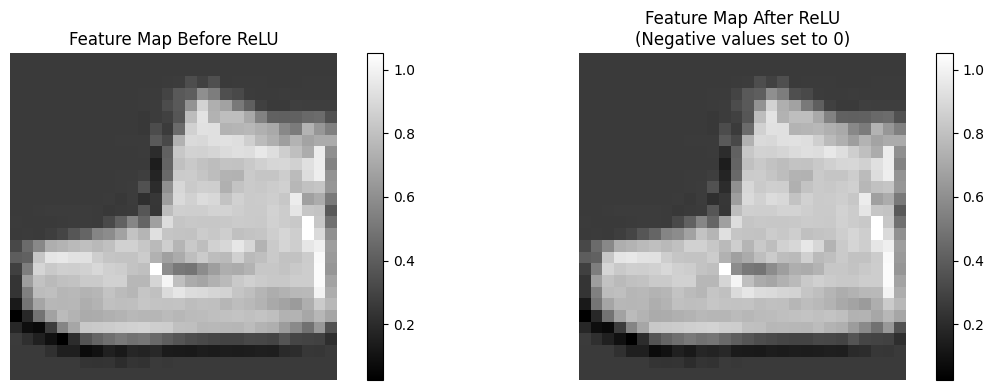

Shape before flattening: torch.Size([1, 6, 14, 14])
Shape after flattening: torch.Size([1, 1176])
Logits shape: torch.Size([1, 10])
Probabilities: tensor([[0.0813, 0.1335, 0.1133, 0.0728, 0.0960, 0.0666, 0.0787, 0.1385, 0.0917,
         0.1276]], grad_fn=<SoftmaxBackward0>)
Predicted class: 7 (Sneaker)
True class: 9 (Ankle boot)


In [6]:
# Demonstration of ReLU activation
relu = nn.ReLU()

# Apply ReLU to our feature maps
features_relu = relu(output_features)

# Visualize the effect of ReLU on one feature map
plt.figure(figsize=(12, 4))

# Before ReLU
plt.subplot(1, 2, 1)
plt.imshow(output_features[0, 0].detach().numpy(), cmap="gray")
plt.title("Feature Map Before ReLU")
plt.colorbar()
plt.axis("off")

# After ReLU
plt.subplot(1, 2, 2)
plt.imshow(features_relu[0, 0].detach().numpy(), cmap="gray")
plt.title("Feature Map After ReLU\n(Negative values set to 0)")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

# Demonstrate flatten operation
# Original shape of pooled features: [1, 6, 14, 14]
print(f"Shape before flattening: {pooled_features.shape}")

# Flatten the tensor (keeping the batch dimension)
flattened = torch.flatten(pooled_features, start_dim=1)
print(f"Shape after flattening: {flattened.shape}")  # Should be [1, 6*14*14]

# Demonstrate a Linear layer
# Input features: 6*14*14 = 1176
# Output features: 10 (for our 10 classes)
fc_layer = nn.Linear(in_features=6 * 14 * 14, out_features=10)

# Apply the fully connected layer
logits = fc_layer(flattened)
print(f"Logits shape: {logits.shape}")  # Should be [1, 10]

# Convert logits to probabilities
probabilities = torch.softmax(logits, dim=1)
print(f"Probabilities: {probabilities}")

# Get the predicted class
predicted_class = torch.argmax(probabilities, dim=1).item()
print(f"Predicted class: {predicted_class} ({class_names[predicted_class]})")
print(f"True class: {sample_label} ({class_names[sample_label]})")

## Building the TinyVGG Model

Now that we understand the key components of CNNs, let's build a simple but effective model called TinyVGG. This is a scaled-down version inspired by the VGG architecture but with significantly fewer parameters.

![VGG Architecture](https://miro.medium.com/v2/resize:fit:1400/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

### TinyVGG Architecture:

1. **Convolutional Block 1**:

   - Conv2d layer (in_channels=1, out_channels=10, kernel_size=3, padding=1)
   - ReLU activation
   - Conv2d layer (in_channels=10, out_channels=10, kernel_size=3, padding=1)
   - ReLU activation
   - MaxPool2d layer (kernel_size=2, stride=2)

2. **Convolutional Block 2**:

   - Conv2d layer (in_channels=10, out_channels=10, kernel_size=3, padding=1)
   - ReLU activation
   - Conv2d layer (in_channels=10, out_channels=10, kernel_size=3, padding=1)
   - ReLU activation
   - MaxPool2d layer (kernel_size=2, stride=2)

3. **Classifier**:
   - Flatten layer
   - Linear layer (in_features=10*7*7, out_features=10)

Let's implement this architecture:


In [7]:
# Define the TinyVGG model as a class
class TinyVGG(nn.Module):
    def __init__(self, input_channels=1, hidden_units=10, output_classes=10):
        super().__init__()

        # Convolutional Block 1
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # Output: [batch_size, hidden_units, 14, 14]
        )

        # Convolutional Block 2
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # Output: [batch_size, hidden_units, 7, 7]
        )

        # Classifier (Flatten + Linear)
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Output: [batch_size, hidden_units*7*7]
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_classes),
        )

    def forward(self, x):
        # Pass input through convolutional blocks and classifier
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


# Instantiate the model
model = TinyVGG(
    input_channels=1,  # FashionMNIST has grayscale images (1 channel)
    hidden_units=10,  # Number of filters in convolutional layers
    output_classes=10,  # FashionMNIST has 10 classes
).to(device)

# Print the model architecture
print(model)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


In [8]:
# Track the tensor dimensions through our model
def track_tensor_dimensions(model, input_tensor):
    """
    Tracks and prints the tensor dimensions as it flows through the model.
    """
    # Original input
    print(f"Input tensor shape: {input_tensor.shape}")

    # Conv Block 1
    conv_block_1_output = model.conv_block_1(input_tensor)
    print(f"After Conv Block 1: {conv_block_1_output.shape}")

    # Conv Block 2
    conv_block_2_output = model.conv_block_2(conv_block_1_output)
    print(f"After Conv Block 2: {conv_block_2_output.shape}")

    # Flattened output
    flattened = torch.flatten(conv_block_2_output, start_dim=1)
    print(f"After Flattening: {flattened.shape}")

    # Final output
    output = model.classifier(conv_block_2_output)
    print(f"Final output (logits): {output.shape}")

    return output


# Create a sample batch to track dimensions
sample_batch, _ = next(iter(train_loader))
sample_batch = sample_batch.to(device)[:1]  # Use just one sample

# Track tensor dimensions through the model
with torch.inference_mode():  # Disable gradient tracking
    _ = track_tensor_dimensions(model, sample_batch)


# Calculate model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


total_params = count_parameters(model)
print(f"\nTotal trainable parameters: {total_params:,}")

# Display model summary with layer names and parameter counts
print("\nModel Summary:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,} parameters")

Input tensor shape: torch.Size([1, 1, 28, 28])
After Conv Block 1: torch.Size([1, 10, 14, 14])
After Conv Block 2: torch.Size([1, 10, 7, 7])
After Flattening: torch.Size([1, 490])
Final output (logits): torch.Size([1, 10])

Total trainable parameters: 7,740

Model Summary:
conv_block_1.0.weight: 90 parameters
conv_block_1.0.bias: 10 parameters
conv_block_1.2.weight: 900 parameters
conv_block_1.2.bias: 10 parameters
conv_block_2.0.weight: 900 parameters
conv_block_2.0.bias: 10 parameters
conv_block_2.2.weight: 900 parameters
conv_block_2.2.bias: 10 parameters
classifier.1.weight: 4,900 parameters
classifier.1.bias: 10 parameters


## Setting Up Training (Loss Function and Optimizer)

Before we train our model, we need to define:

1. **Loss Function**: Measures how far our model's predictions are from the true labels. For multi-class classification like FashionMNIST, we use Cross-Entropy Loss.

2. **Optimizer**: Updates the model's weights based on the calculated gradients to minimize the loss. We'll use Adam, which is a popular optimization algorithm that adapts the learning rate for each parameter.

3. **Evaluation Metrics**: To track our model's performance during training, we'll use accuracy (proportion of correctly classified images).

Let's set these up:


In [9]:
# Set up loss function
loss_fn = nn.CrossEntropyLoss()

# Set up optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)


# Define function to calculate accuracy
def accuracy_fn(y_pred, y_true):
    """
    Calculates accuracy of predictions.

    Args:
        y_pred: Predicted logits or probabilities
        y_true: True labels

    Returns:
        accuracy: Percentage of correct predictions
    """
    # Convert logits to class predictions
    y_pred_class = torch.argmax(y_pred, dim=1)

    # Calculate accuracy
    correct = torch.eq(y_pred_class, y_true).sum().item()
    accuracy = correct / len(y_true) * 100

    return accuracy


print(f"Loss function: {loss_fn}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate: {learning_rate}")
print("Using accuracy as evaluation metric")

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.001
Using accuracy as evaluation metric


## Training and Evaluation Loop

Now we'll implement a training loop that:

1. Iterates over the training data for a specified number of epochs
2. For each batch:
   - Performs a forward pass through the model
   - Calculates the loss
   - Performs backpropagation
   - Updates the model parameters
3. Evaluates the model on the test set after each epoch
4. Tracks and reports metrics (loss and accuracy)

This process helps the model learn patterns in the data and improve its predictions over time.


In [10]:
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Define training function
def train_step(model, dataloader, loss_fn, optimizer, device):
    """
    Performs one training epoch.

    Args:
        model: PyTorch model to train
        dataloader: DataLoader containing training data
        loss_fn: Loss function
        optimizer: Optimizer for weight updates
        device: Device to train on (CPU or GPU)

    Returns:
        train_loss: Average loss for the epoch
        train_accuracy: Average accuracy for the epoch
    """
    # Set model to training mode
    model.train()

    # Initialize metrics
    train_loss, train_acc = 0, 0

    # Create progress bar
    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(progress_bar):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Calculate accuracy
        acc = accuracy_fn(y_pred, y)
        train_acc += acc

        # 4. Optimizer zero grad
        optimizer.zero_grad()

        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

    # Calculate average metrics
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


# Define testing function
def test_step(model, dataloader, loss_fn, device):
    """
    Performs one evaluation epoch.

    Args:
        model: PyTorch model to evaluate
        dataloader: DataLoader containing test data
        loss_fn: Loss function
        device: Device to test on (CPU or GPU)

    Returns:
        test_loss: Average loss for the epoch
        test_accuracy: Average accuracy for the epoch
    """
    # Set model to evaluation mode
    model.eval()

    # Initialize metrics
    test_loss, test_acc = 0, 0

    # Create progress bar
    progress_bar = tqdm(dataloader, desc="Testing", leave=False)

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(progress_bar):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # 3. Calculate accuracy
            acc = accuracy_fn(y_pred, y)
            test_acc += acc

    # Calculate average metrics
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


# Set number of epochs
epochs = 5

# Create results tracking dictionary
results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

# Training loop
print(f"Training TinyVGG model on {device} for {epochs} epochs...\n")

# Start training timer - using time module instead of CUDA events for compatibility
import time

start_time = time.time()

# Loop through epochs with progress bar
for epoch in tqdm(range(epochs), desc="Epochs"):
    # Train step
    train_loss, train_acc = train_step(
        model=model,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
    )

    # Test step
    test_loss, test_acc = test_step(
        model=model, dataloader=test_loader, loss_fn=loss_fn, device=device
    )

    # Print results
    print(
        f"Epoch {epoch + 1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%"
    )

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

# End training timer
end_time = time.time()
print(f"\nTraining time: {end_time - start_time:.2f} seconds")

Training TinyVGG model on cpu for 5 epochs...



Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.5923, Train Acc: 78.63% - Test Loss: 0.4209, Test Acc: 84.25%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.3653, Train Acc: 86.90% - Test Loss: 0.3624, Test Acc: 87.11%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.3261, Train Acc: 88.24% - Test Loss: 0.3558, Test Acc: 87.05%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.3040, Train Acc: 89.02% - Test Loss: 0.3119, Test Acc: 88.79%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.2865, Train Acc: 89.66% - Test Loss: 0.3045, Test Acc: 89.20%

Training time: 122.39 seconds


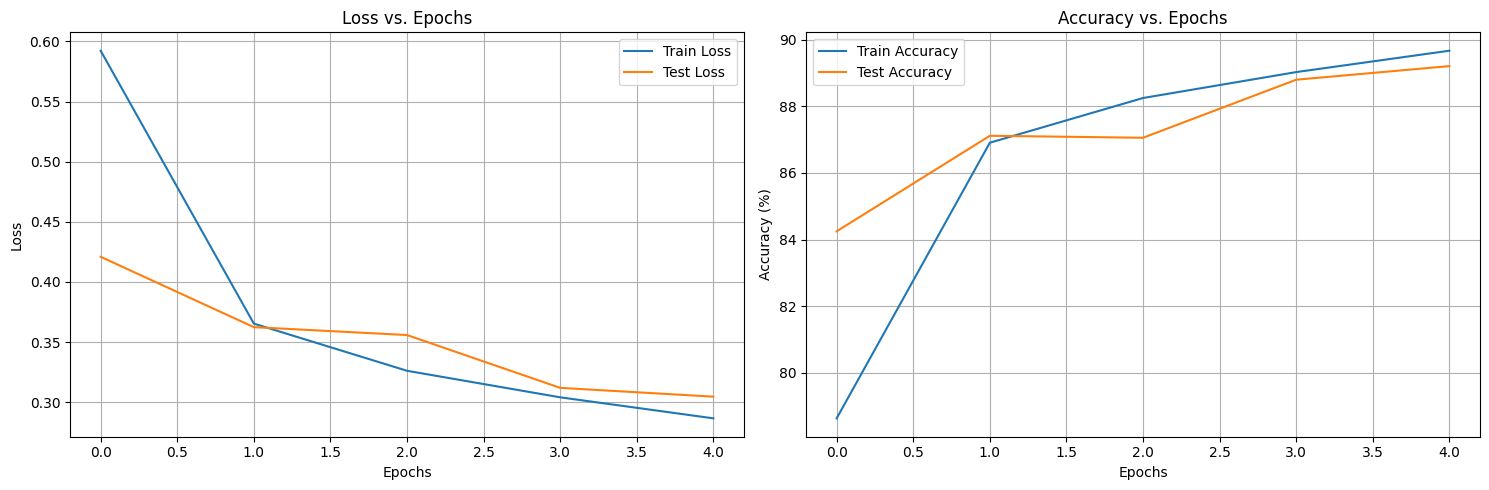

In [11]:
# Visualize training results
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Model Evaluation with Confusion Matrix

A confusion matrix is a table that visualizes the performance of a classification model. It shows:

- True positives: Correctly predicted positive instances
- False positives: Incorrectly predicted positive instances
- True negatives: Correctly predicted negative instances
- False negatives: Incorrectly predicted negative instances

By analyzing the confusion matrix, we can:

1. Identify which classes the model confuses with each other
2. Understand if the model has a bias toward certain classes
3. Find opportunities to improve the model's performance

![Confusion Matrix Visualization](https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_001.png)

Let's create a confusion matrix to evaluate our trained TinyVGG model:


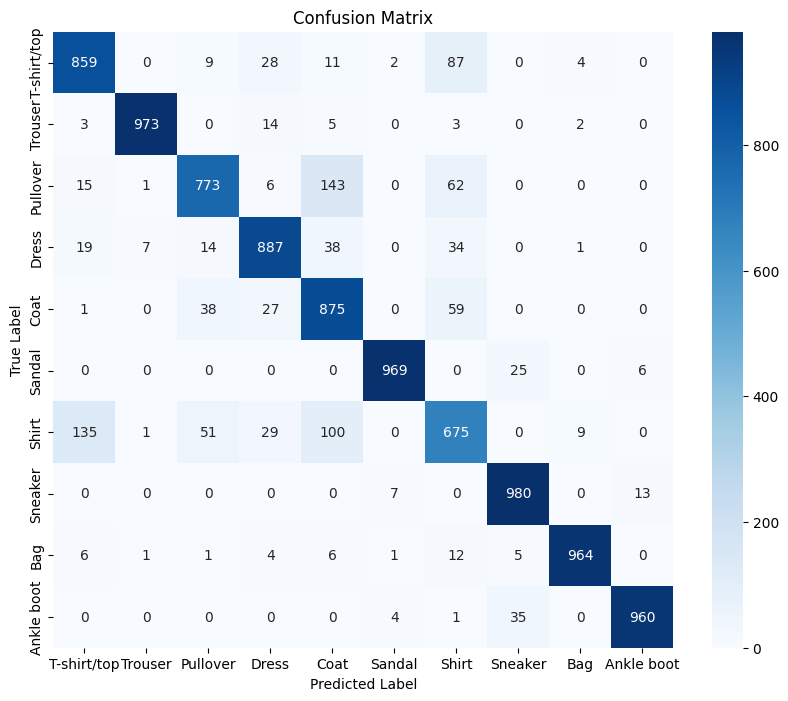

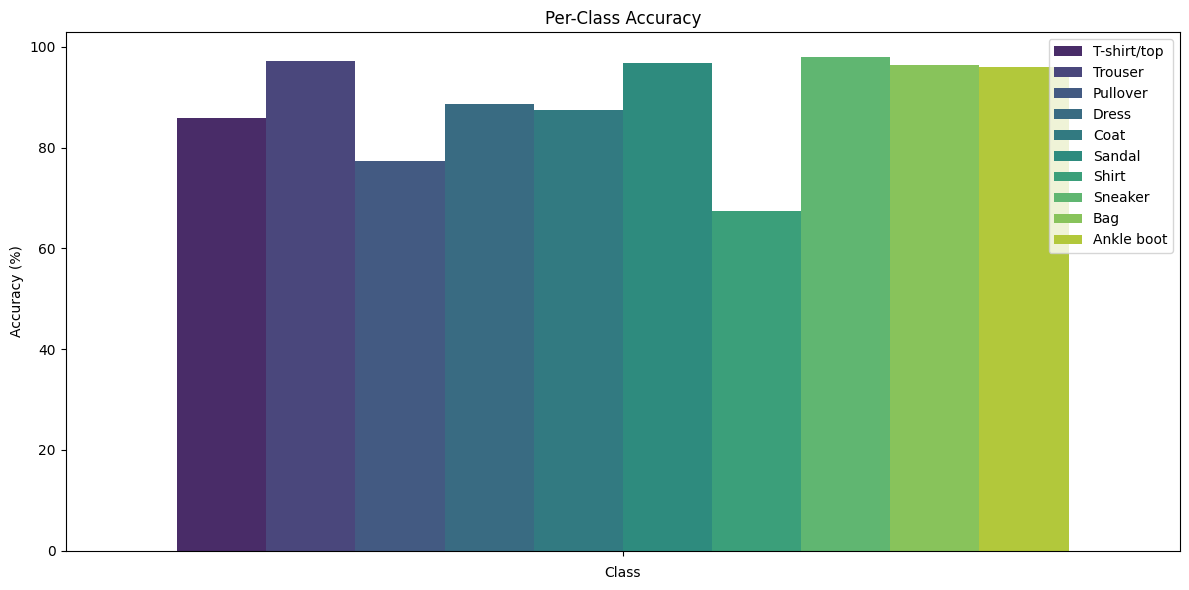

Per-class accuracy:
T-shirt/top: 85.90%
Trouser: 97.30%
Pullover: 77.30%
Dress: 88.70%
Coat: 87.50%
Sandal: 96.90%
Shirt: 67.50%
Sneaker: 98.00%
Bag: 96.40%
Ankle boot: 96.00%


In [12]:
# Create functions to get predictions from our model
def make_predictions(model, data_loader, device):
    """
    Makes predictions on a given data loader with a specified model.

    Args:
        model: PyTorch model in evaluation mode
        data_loader: DataLoader to make predictions on
        device: Device to perform computation

    Returns:
        y_preds: Predicted labels
        y_true: True labels
    """
    model.eval()
    y_preds = []
    y_true = []

    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to device
            X, y = X.to(device), y.to(device)

            # Make predictions
            y_pred = model(X)
            y_pred_labels = torch.argmax(y_pred, dim=1)

            # Append to lists
            y_preds.append(y_pred_labels.cpu())
            y_true.append(y.cpu())

    # Concatenate lists
    y_preds = torch.cat(y_preds)
    y_true = torch.cat(y_true)

    return y_preds, y_true


# Make predictions on the test set
y_preds, y_true = make_predictions(model=model, data_loader=test_loader, device=device)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true.numpy(), y_preds.numpy())

# Create a pretty confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Calculate per-class accuracy
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1) * 100

# Display per-class accuracy
plt.figure(figsize=(12, 6))
sns.barplot(hue=class_names, y=per_class_accuracy, palette="viridis")
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Print per-class accuracy
print("Per-class accuracy:")
for i, (class_name, accuracy) in enumerate(zip(class_names, per_class_accuracy)):
    print(f"{class_name}: {accuracy:.2f}%")

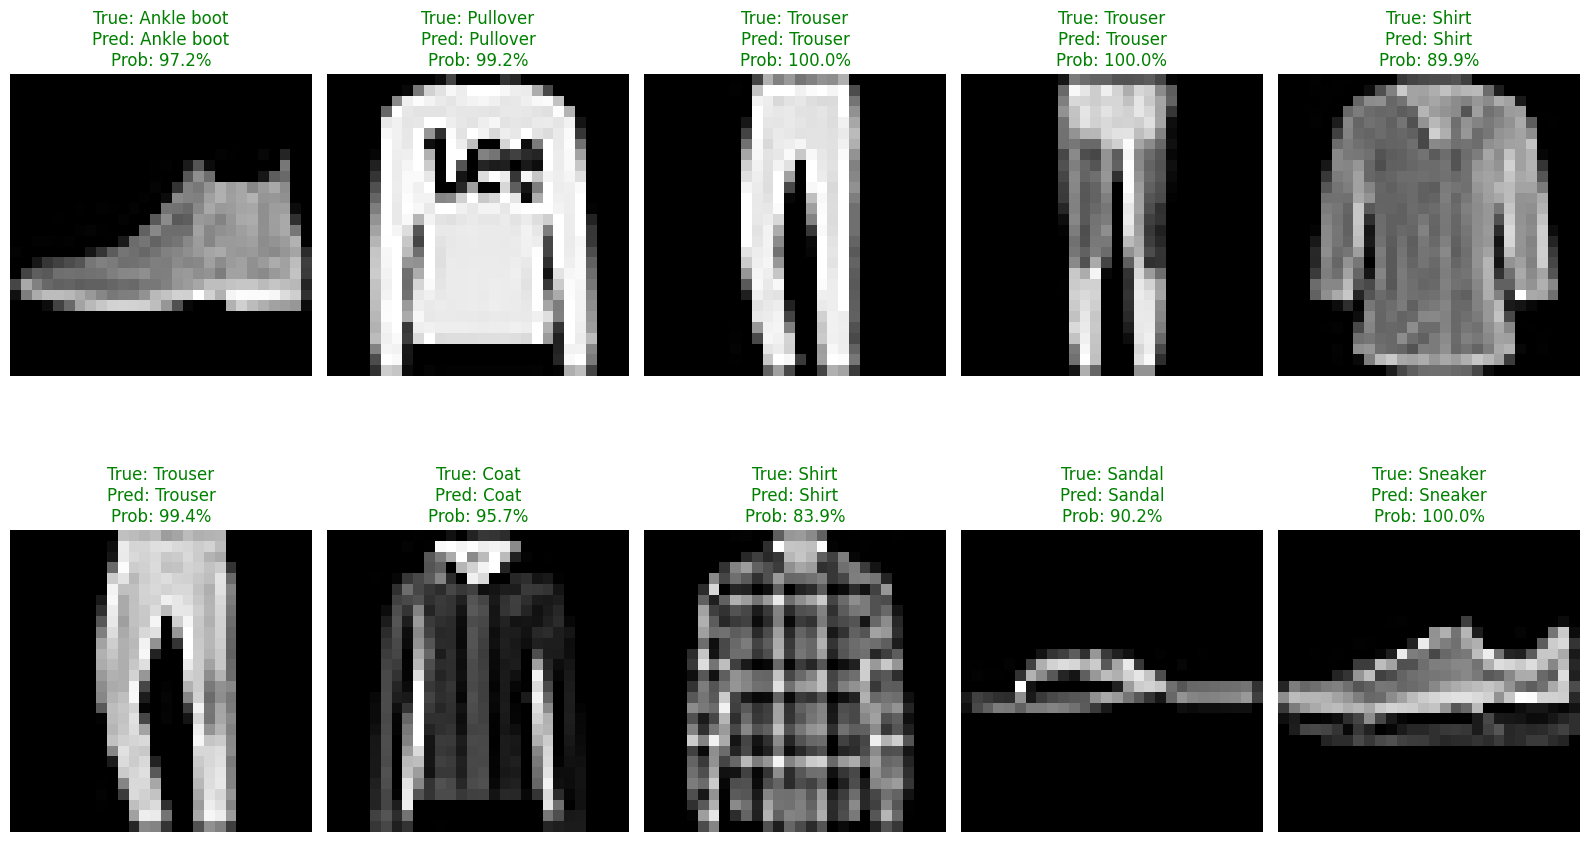

In [13]:
# Let's visualize some predictions
def plot_random_predictions(model, data_loader, class_names, device, n=10):
    """
    Makes predictions on random samples and plots them.

    Args:
        model: PyTorch model in evaluation mode
        data_loader: DataLoader containing the data
        class_names: List of class names
        device: Device to perform computation
        n: Number of samples to plot
    """
    # Get a random batch of images
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    model.eval()
    with torch.inference_mode():
        pred_logits = model(images[:n])
        pred_probs = torch.softmax(pred_logits, dim=1)
        pred_labels = torch.argmax(pred_probs, dim=1)

    # Plot images with predictions
    plt.figure(figsize=(16, 10))
    for i in range(n):
        plt.subplot(2, n // 2, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap="gray")

        # Get prediction information
        true_label = class_names[labels[i]]
        pred_label = class_names[pred_labels[i]]
        prob = torch.max(pred_probs[i]).item() * 100

        # Set color based on correct/incorrect prediction
        color = "green" if pred_labels[i] == labels[i] else "red"

        # Add title with predictions
        plt.title(
            f"True: {true_label}\nPred: {pred_label}\nProb: {prob:.1f}%", color=color
        )
        plt.axis(False)

    plt.tight_layout()
    plt.show()


# Visualize some predictions
plot_random_predictions(
    model=model, data_loader=test_loader, class_names=class_names, device=device, n=10
)

## Conclusion

In this notebook, we've explored Convolutional Neural Networks (CNNs) using PyTorch and the FashionMNIST dataset. Here's a summary of what we've learned:

1. **CNN Fundamentals**:

   - We explored the key components of CNNs, including convolutional layers, pooling layers, and fully connected layers
   - We visualized how each layer transforms the input data

2. **TinyVGG Architecture**:

   - We built a simplified version of the VGG architecture
   - We tracked tensor dimensions through the model to understand how data flows
   - We analyzed model parameters

3. **Training Process**:

   - We set up loss function (Cross-Entropy Loss) and optimizer (Adam)
   - We implemented a comprehensive training and evaluation loop
   - We visualized training progress over epochs

4. **Model Evaluation**:
   - We used accuracy as our primary metric
   - We created a confusion matrix to understand model strengths and weaknesses
   - We analyzed per-class accuracy to identify which classes were harder to classify
   - We visualized model predictions on test examples

### Further Improvements

To improve the model's performance, you could try:

1. **Architecture Modifications**:

   - Add more convolutional layers or increase filters
   - Experiment with different kernel sizes
   - Implement skip connections

2. **Regularization Techniques**:

   - Add dropout layers
   - Apply batch normalization
   - Use data augmentation

3. **Hyperparameter Tuning**:

   - Adjust learning rate
   - Try different optimizers
   - Train for more epochs

4. **Transfer Learning**:
   - Use pre-trained models like ResNet, VGG, or EfficientNet
   - Fine-tune on the FashionMNIST dataset

CNNs remain a cornerstone of computer vision tasks, and the principles learned here apply to more complex models and datasets.


## Extra Resources

**Videos:**

- [MIT's 6.S191: Convolutional Neural Networks](https://www.youtube.com/watch?v=iaSUYvmCekI&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=4)
- [But What is a Convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA)

**Articles:**

- [Wikipedia: Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network)
- [An Introduction to Convolutional Neural Networks](https://www.datacamp.com/tutorial/introduction-to-convolutional-neural-networks-cnns)
- [An Intuitive Explanation of Convolutional Neural Networks](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)
- [What is a Convolutional Neural Network?](https://www.mathworks.com/discovery/convolutional-neural-network.html)

You can checkout [CNN Explainer](https://poloclub.github.io/cnn-explainer/) and play around to visualize the architecture and operations of CNNs.
